# Optimizing Hyperparameters by Maximizing the Marginal Likelihood

I use `autograd` to maximize the noise variance and the kernel hyperparameter by maximizing the log marginal likelihood, which is analytically tractable in the full-rank Gaussian process case.

val Autograd ArrayBox with value 144.68818881575086 sigma Autograd ArrayBox with value 2.0 tau Autograd ArrayBox with value 1.25
val Autograd ArrayBox with value 141.3462944553479 sigma Autograd ArrayBox with value 1.8500000000768269 tau Autograd ArrayBox with value 1.1000000007715407
val Autograd ArrayBox with value 137.73261798384286 sigma Autograd ArrayBox with value 1.6998184982138764 tau Autograd ArrayBox with value 0.9498005906329526
val Autograd ArrayBox with value 133.80042739662437 sigma Autograd ArrayBox with value 1.5493270386412774 tau Autograd ArrayBox with value 0.7992743546058649
val Autograd ArrayBox with value 129.4894797321498 sigma Autograd ArrayBox with value 1.3983925151807106 tau Autograd ArrayBox with value 0.6483058254141242


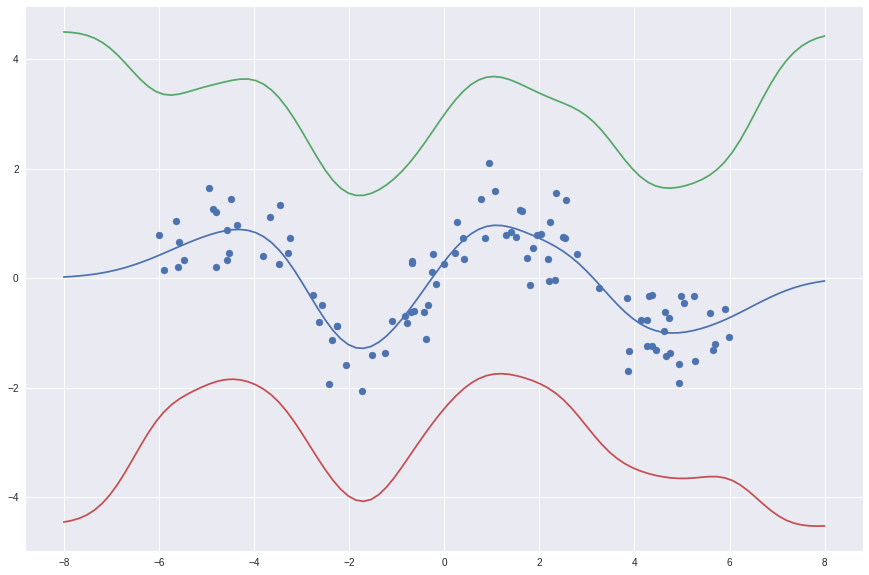

val Autograd ArrayBox with value 124.71688572971982 sigma Autograd ArrayBox with value 1.2468785325155167 tau Autograd ArrayBox with value 0.4968212543598258
val Autograd ArrayBox with value 119.47156262824097 sigma Autograd ArrayBox with value 1.0968785325668988 tau Autograd ArrayBox with value 0.3468212547361067
val Autograd ArrayBox with value 113.99257726024861 sigma Autograd ArrayBox with value 0.94667546115303 tau Autograd ArrayBox with value 0.1966176589741935
val Autograd ArrayBox with value 109.31560493119694 sigma Autograd ArrayBox with value 0.7961348310186898 tau Autograd ArrayBox with value 0.12641187312526236
val Autograd ArrayBox with value 102.10475310522378 sigma Autograd ArrayBox with value 0.6451407280936192 tau Autograd ArrayBox with value 0.20063685772517575


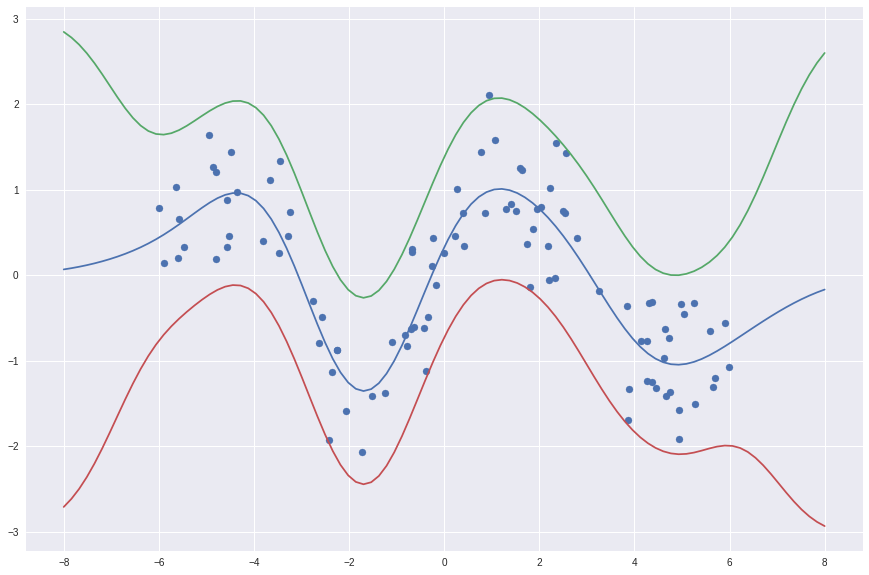

val Autograd ArrayBox with value 95.35699010680332 sigma Autograd ArrayBox with value 0.4935399385519492 tau Autograd ArrayBox with value 0.2712049672757566
val Autograd ArrayBox with value 91.1567885157202 sigma Autograd ArrayBox with value 0.3435399385847508 tau Autograd ArrayBox with value 0.12120496770766959
val Autograd ArrayBox with value 88.06439620743882 sigma Autograd ArrayBox with value 0.19784044133681158 tau Autograd ArrayBox with value 0.2274865390884753
val Autograd ArrayBox with value 88.44005500192962 sigma Autograd ArrayBox with value 0.1916215832159309 tau Autograd ArrayBox with value 0.3170353419262101
val Autograd ArrayBox with value 87.04827186206583 sigma Autograd ArrayBox with value 0.24335996865965204 tau Autograd ArrayBox with value 0.38900569073645846


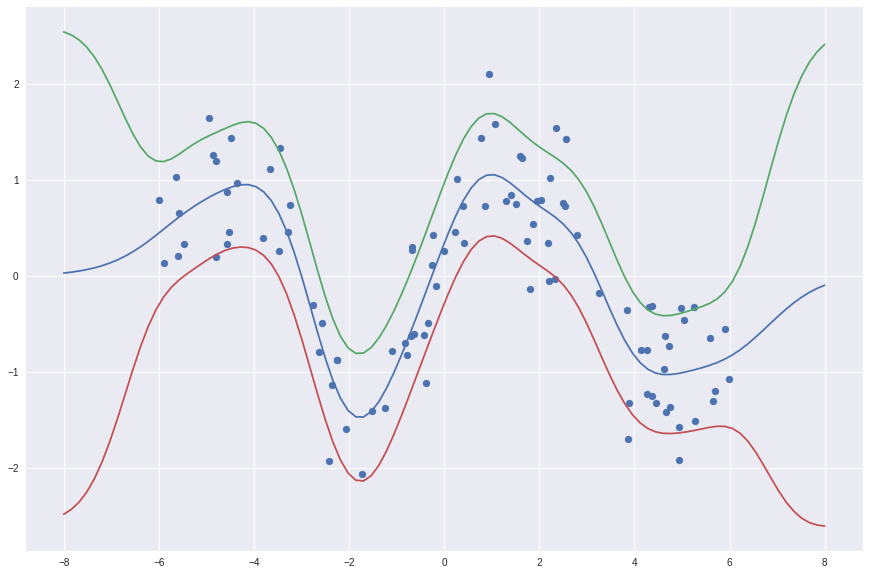

val Autograd ArrayBox with value 87.74836804418769 sigma Autograd ArrayBox with value 0.2872590003979773 tau Autograd ArrayBox with value 0.44811150251149845
val Autograd ArrayBox with value 96.36401603071651 sigma Autograd ArrayBox with value 0.13725900045805792 tau Autograd ArrayBox with value 0.2981115033662835
val Autograd ArrayBox with value 86.97347146359554 sigma Autograd ArrayBox with value 0.2388011261337321 tau Autograd ArrayBox with value 0.34397460474052355
val Autograd ArrayBox with value 88.23616290052705 sigma Autograd ArrayBox with value 0.3193070366224638 tau Autograd ArrayBox with value 0.31718642794123725
val Autograd ArrayBox with value 90.01868529789789 sigma Autograd ArrayBox with value 0.37423383385162373 tau Autograd ArrayBox with value 0.2398041512078277


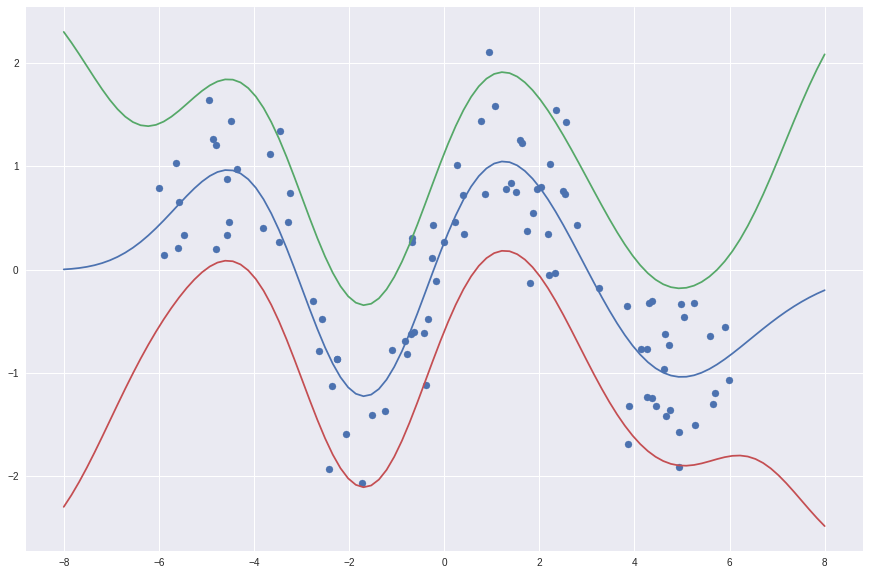

val Autograd ArrayBox with value 91.84338470213348 sigma Autograd ArrayBox with value 0.4076819205413725 tau Autograd ArrayBox with value 0.16945982864837392
val Autograd ArrayBox with value 86.92176459433173 sigma Autograd ArrayBox with value 0.2576819205770313 tau Autograd ArrayBox with value 0.31945982855538635
val Autograd ArrayBox with value 95.21910396200688 sigma Autograd ArrayBox with value 0.13959269601697316 tau Autograd ArrayBox with value 0.3947108807013277
val Autograd ArrayBox with value 87.25237343279969 sigma Autograd ArrayBox with value 0.217230646125393 tau Autograd ArrayBox with value 0.49058938373683214
val Autograd ArrayBox with value 87.93225484880423 sigma Autograd ArrayBox with value 0.28746479208839726 tau Autograd ArrayBox with value 0.5756368665533165


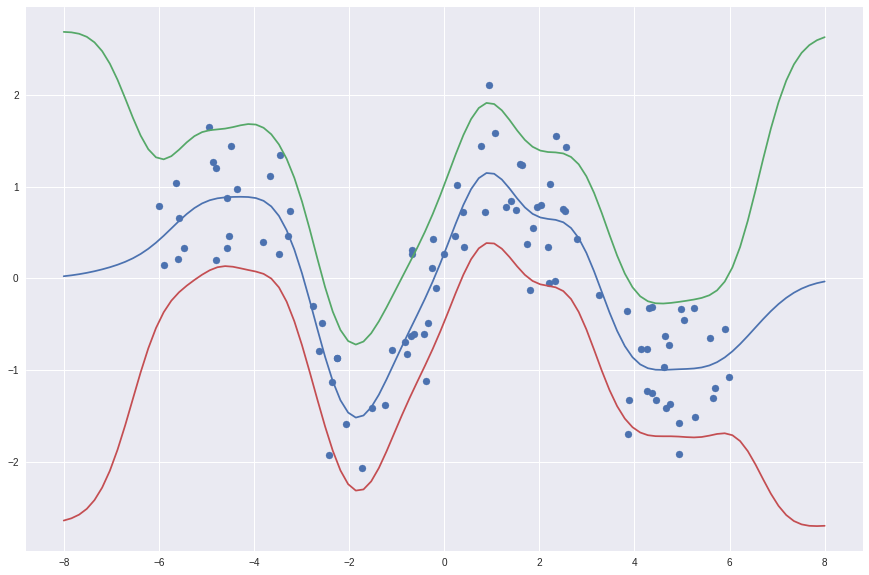

In [0]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

from autograd import grad
from autograd.misc.optimizers import adam



inputs = np.linspace(-6, 6, 200)
tau = 0.5
sigma = 0.5
x = np.random.uniform(-6, 6, 100)
y = np.sin(x) + np.random.normal(0, sigma, x.shape)

def covariance(x, x_, tau = tau):
    return np.exp(-tau * (x - x_)**2)

def sample_prior(inputs):
    dim = (inputs.shape[0], inputs.shape[0])
    kff = np.zeros(shape=dim)
    X, Y = np.meshgrid(inputs, inputs)
    cov = covariance(X, Y)
    return scipystats.multivariate_normal.rvs(np.zeros(shape=dim[0]), cov)
    
def gram_matrix(x, x_ = None, covariance = covariance, tau = tau):
    if x_ == None:
        dim = (x.shape[0], x.shape[0])
        new = x
    else:
        new = np.hstack((x, x_))
        dim = (new.shape[0], new.shape[0])
    
    X_grid, Y_grid = np.meshgrid(new, new)
    gram = covariance(X_grid, Y_grid, tau)
    
    kxx = gram[:x.shape[0], :x.shape[0]]
    kx_x = gram[x.shape[0]:, :x.shape[0]]
    kxx_ = gram[:x.shape[0], x.shape[0]:]
    kx_x_ = gram[x.shape[0]:, x.shape[0]:]
    
    return gram, kxx, kx_x, kxx_, kx_x_

def inference_confidence_intervals(query, sigma, tau, x = x, y = y):
    mean = []
    variance = []
    for pred in query:
        pred = np.array([pred])
        gram, kxx, kx_x, kxx_, kx_x_ = gram_matrix(x, pred, tau = tau)

        inv = kx_x.dot(np.linalg.inv(kxx + sigma * np.eye(x.shape[0])))
        pred_mean = inv.dot(y)
        pred_var = kx_x_ - inv.dot(kxx_) + sigma
        mean.append(pred_mean)
        variance.append(pred_var)

    #     variance.append()
    mean = np.array(mean)
    variance = np.squeeze(variance)
    return mean, variance

    
def marginal(params, t):
    sigma, tau = params
    gram, kxx, kx_x, kxx_, kx_x_ = gram_matrix(x, tau = tau)
    cov_w_noise = kxx + sigma * np.eye(x.shape[0])
    first_term = -0.5 * y.T.dot(np.linalg.inv(cov_w_noise)).dot(y)
    second_term = -0.5 * np.log(np.linalg.det(cov_w_noise))
    third_term = -x.shape[0]/2 * np.log(2 * np.pi)
    val = first_term + second_term + third_term
    print("val", -val, "sigma", sigma, "tau", tau)
    return(-val)
    

gradient = grad(marginal)
sigma, tau = [2.0, 1.25]
query = np.linspace(-8, 8, 100)
for _ in range(5):
    plt.figure(figsize=(15,10))
    plt.scatter(x, y)
    sigma, tau = adam(gradient, [sigma, tau], step_size=0.15, num_iters=5)
    mean, variance = inference_confidence_intervals(query, sigma, tau)
    plt.plot(query, mean.T[0])
    plt.plot(query, mean.T[0] + 2*variance)
    plt.plot(query, mean.T[0] - 2*variance)
    plt.show()

# Comparing with GPy Implementation

The following code implements Gaussian Process Regression in GPy

In [0]:
! pip install GPy
import GPy
import numpy as np
np.random.seed(101)

N = 50
noise_var = 0.05

X = np.linspace(0,10,50)[:,None]
k = GPy.kern.RBF(1)
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)



Name : GP regression
Objective : 50.08607234686575
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |    1.658248604609694  |      +ve      |        
  rbf.lengthscale          |     1.11215383150294  |      +ve      |        
  Gaussian_noise.variance  |  0.23613423686500662  |      +ve      |        


 /usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


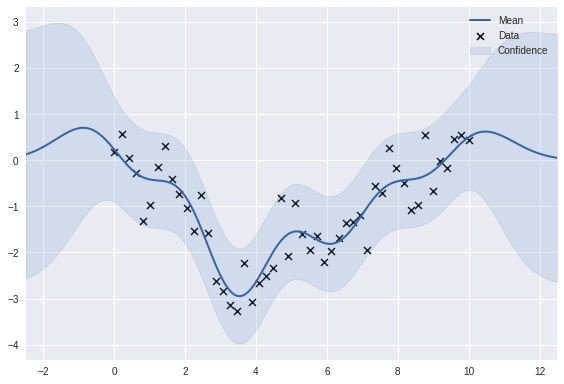

In [0]:
m_full = GPy.models.GPRegression(X,y)
m_full.optimize('bfgs')
m_full.plot()
print (m_full)


Name : sparse_gp
Objective : 260.8098280164652
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing_inputs          |  (6, 1)  |               |        
  rbf.variance             |     1.0  |      +ve      |        
  rbf.lengthscale          |     1.0  |      +ve      |        
  Gaussian_noise.variance  |    0.05  |      +ve      |        


 /usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


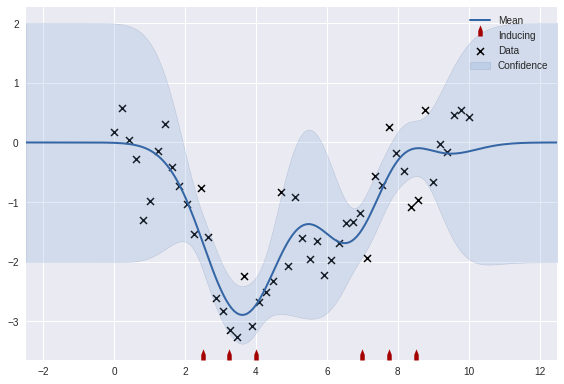

In [0]:
Z = np.hstack((np.linspace(2.5,4.,3),np.linspace(7,8.5,3)))[:,None]
m = GPy.models.SparseGPRegression(X,y,Z=Z)
m.likelihood.variance = noise_var
m.plot()
print (m)

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from scipy import stats as scipystats
import numpy 
sns.set()

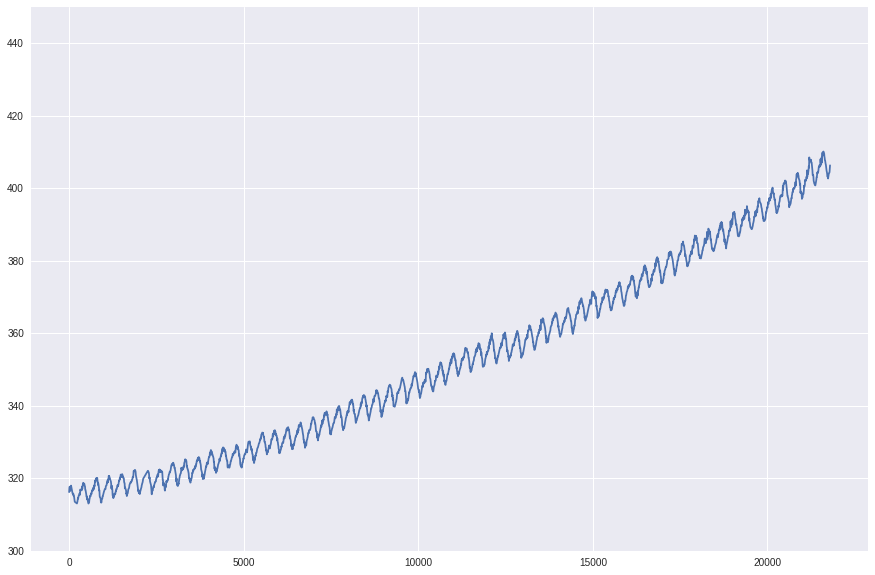

In [0]:
def days_between(row):
    d1 = datetime(1958, 3, 29, 0, 0)
    d2 = datetime.strptime(row["DATE"], "%m-%d-%Y")
    return abs((d2 - d1).days)

def process_time(row): 
    # format time to %m-%d-%Y
    time = row["DATE"].split("/")
    time[0] = '0' + time[0] if int(time[0]) < 10 else time[0]
    time[1] = '0' + time[1] if int(time[1]) < 10 else time[1]
    time[2] = '20' + time[2] if int(time[2]) < 50 else '19' + time[2]
    return "-".join(time)

downloaded.GetContentFile('Filename.csv')  
data = pd.read_csv('Filename.csv')  
data.loc[:, "DATE"] = (data.apply(process_time, axis=1))
data["TimeDiff"] = (data.apply(days_between, axis=1))
plt.figure(figsize=(15,10))
plt.ylim(300, 450)
plt.plot(data["TimeDiff"], data["CO2"])

In [0]:
X = np.array(data["TimeDiff"])[:, None]
y = np.array(data["CO2"])[:, None]
# m_full = GPy.models.GPRegression(X,y)
# m_full.optimize('bfgs')
# m_full.plot()
# print (m_full)

In [88]:
Z = np.hstack((np.linspace(2.5,21000,300)))[:,None]
Z.shape
m = GPy.models.SparseGPRegression(X,y,Z=Z)
m.likelihood.variance = noise_var
m.plot()
print (m)

(300, 1)

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f50874d2b70>],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f50874c1860>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f50874d2828>]],
 'inducing': <matplotlib.collections.PathCollection at 0x7f50874d2be0>}

 /usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


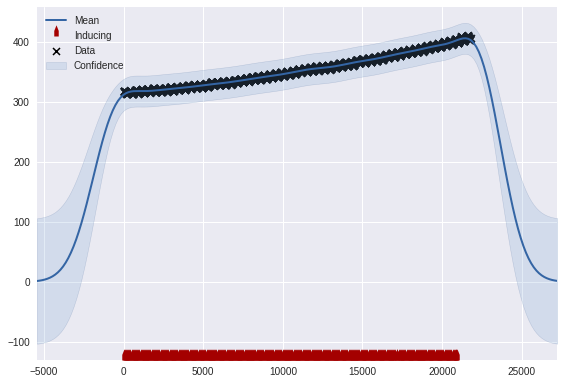

In [0]:
m.randomize()
m.Z.unconstrain()
m.optimize('bfgs')
m.plot()

We see that the bound is much tigher in the full rank case and the bound is much less tight in the sparse GP regression.


Name : sparse_gp
Objective : 7407.2272986881435
Number of Parameters : 303
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |               value  |  constraints  |  priors
  inducing_inputs          |            (300, 1)  |     fixed     |        
  rbf.variance             |  1147.3095722914272  |      +ve      |        
  rbf.lengthscale          |  1200.8740017486464  |      +ve      |        
  Gaussian_noise.variance  |   8.039174852162075  |      +ve      |        


 /usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


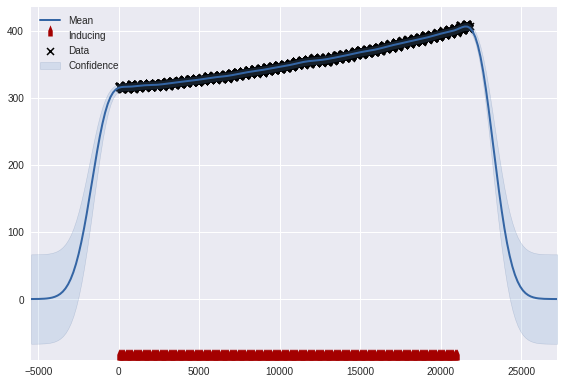

In [0]:
m.inducing_inputs.fix()
m.optimize('bfgs')
m.plot()
print (m)

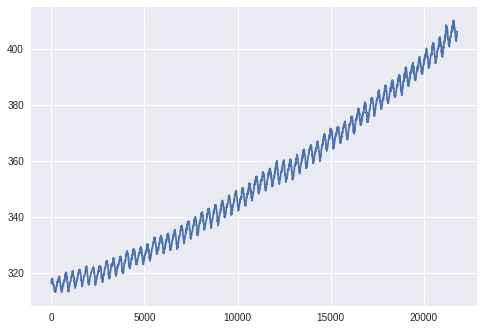

In [34]:
plt.plot(X, y)

# Using Variational Inference to Infer Inducing Inputs for the Mauna Loa Data set

I will use the estimate of the Evidence Lower Bound (ELBO) and automatic differentiation in PyTorch to estimate the locations of the inducing inputs. 

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [59]:
import torch
import numpy as np

# Generate toy data in torch
# x = torch.empty(100).uniform_(-6)
x = torch.Tensor(X).reshape(X.shape[0])
y = torch.Tensor(y).reshape(X.shape[0])
# y = torch.sin(x) + torch.normal(torch.zeros_like(x), 0.1)

# squared exponential covariance function
def covariance(x, x_, tau):
    return torch.exp(-tau * (x - x_)**2)

def kernel(x_vec, y_vec, tau):
    """ 
    Returns the covariance matrix between two vectors 
    """
    Y_grid, X_grid = torch.meshgrid([y_vec , x_vec]) 
    return covariance(X_grid, Y_grid, tau)
  
def elbo_calc(params, t):
    def unpack_params(params):
        sigma, tau, inducing_points = params[0], params[1], params[2:]
        print(sigma, tau)
        return sigma, tau, inducing_points
    
    sigma, tau, inducing_points = unpack_params(params)
    n = x.shape[0] 
    
    
    # build kmm Gram matrix between inducing inputs
    kmm = kernel(inducing_points, inducing_points, tau)
    
    # enforce numerical stability by symmetrizing matrix
    kmm = torch.triu(kmm)
    kmm = torch.triu(kmm, diagonal = 1) + torch.transpose(kmm, 0, 1)
    inv_kmm = torch.inverse(kmm)
    kmi = kernel(inducing_points, x, tau)
    kim = torch.transpose(kmi, 0, 1)
    
    
    # first term
    U, S, V = (torch.svd(kmm))
    elbo = 1.0/2 * torch.sum(torch.log(S))
    print("elbo after first term", elbo)
    
    # second term
    sum_kmi_kim = torch.einsum("ij,ki->jk", [kmi, kim])
    pred_cov = kmm + sigma * sum_kmi_kim
    U, S, V = (torch.svd(pred_cov))
    elbo -= 1.0/2 * torch.sum(torch.log(S))
    print("elbo after second term", elbo)
    
    # third term
    elbo -= n/2 * torch.log(2 * np.pi / sigma)
    print("elbo after third term", elbo)
    
    # fourth term
    fourth_term = torch.dot(y, y) + torch.sum(covariance(x, x, tau))
    
    
    for point in range(n):
        kmi_term = kmi[point].reshape((inducing_points.shape[0], 1))
        kim_term = torch.transpose(kmi_term, 0, 1)
        mat = torch.mm(torch.mm(inv_kmm, kmi_term), kim_term)
        fourth_term -= torch.trace(mat)
    elbo -= sigma/2 * fourth_term
    print("elbo after fourth term", elbo)
    kmi_yi = ((kmi * y.reshape((y.shape[0], 1))))
    fifth_term = torch.mm(torch.mm(kmi_yi, torch.inverse(pred_cov)), torch.transpose(kmi_yi, 0, 1)) 
    elbo += sigma**2/2 * torch.trace(fifth_term)
    print("sigma", sigma)
    print("penalty", 1e8 * torch.log(sigma))
    return -elbo - 0.99**t * torch.log(tau) - 1e8 * torch.log(sigma)

init_inducing = torch.linspace(0, 21000, 300) + 3 * torch.randn(300)
init_sigma = torch.tensor([1.0])
init_tau = torch.tensor([0.5])
init_params = torch.cat((init_sigma, init_tau, init_inducing), 0)
var = torch.autograd.Variable(init_params, requires_grad=True)
import torch.optim as optim
optimizer = optim.Adam([var])
optimizer.zero_grad()
elbo = elbo_calc(var, 1)

def adaptive(variables, callback=None, num_iters=200, step_size=0.1, mass=0.9):
    """Stochastic gradient descent with momentum.
    grad() must have signature grad(x, i), where i is the iteration number."""
    velocity = torch.zeros(len(variables))
    for i in range(num_iters):
        elbo = elbo_calc(variables, i)
        print("Elbo is", elbo)
        elbo.backward()
        if callback: callback(variables, i, variables.grad)
        velocity = mass * velocity - (1.0 - mass) * variables.grad
        velocity = velocity / torch.norm(velocity)
        variables = torch.autograd.Variable(variables + step_size * velocity, requires_grad=True) 
    return variables
  

variables = adaptive(var, num_iters=20, step_size=0.1)

tensor(1., grad_fn=<SelectBackward>) tensor(0.5000, grad_fn=<SelectBackward>)
elbo after first term tensor(0., grad_fn=<MulBackward0>)
elbo after second term tensor(-28.8990, grad_fn=<SubBackward0>)
elbo after third term tensor(-2825.2288, grad_fn=<SubBackward0>)
elbo after fourth term tensor(-1.9106e+08, grad_fn=<SubBackward0>)
sigma tensor(1., grad_fn=<SelectBackward>)
penalty tensor(0., grad_fn=<MulBackward0>)
tensor(1., grad_fn=<SelectBackward>) tensor(0.5000, grad_fn=<SelectBackward>)
elbo after first term tensor(0., grad_fn=<MulBackward0>)
elbo after second term tensor(-28.8990, grad_fn=<SubBackward0>)
elbo after third term tensor(-2825.2288, grad_fn=<SubBackward0>)
elbo after fourth term tensor(-1.9106e+08, grad_fn=<SubBackward0>)
sigma tensor(1., grad_fn=<SelectBackward>)
penalty tensor(0., grad_fn=<MulBackward0>)
Elbo is tensor(1.8823e+08, grad_fn=<SubBackward0>)
tensor(1.1000, grad_fn=<SelectBackward>) tensor(0.5000, grad_fn=<SelectBackward>)
elbo after first term tensor(0., 


Name : sparse_gp
Objective : 19068316.370652895
Number of Parameters : 303
Number of Optimization Parameters : 303
Updates : True
Parameters:
  sparse_gp.               |     value  |  constraints  |  priors
  inducing_inputs          |  (300, 1)  |               |        
  rbf.variance             |       1.0  |      +ve      |        
  rbf.lengthscale          |       1.0  |      +ve      |        
  Gaussian_noise.variance  |      10.0  |      +ve      |        


 /usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


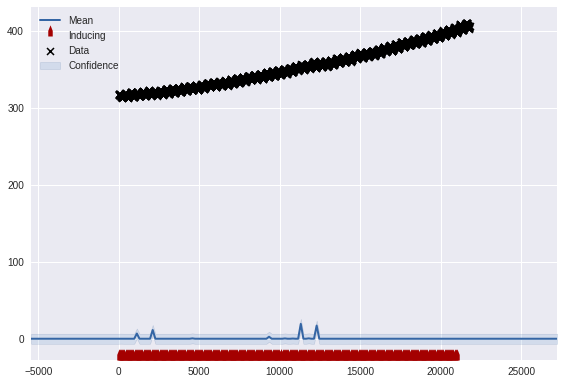

In [91]:
sigma, tau, inducing_points = variables[0], variables[1], variables[2:]
Z = inducing_points.detach().numpy()[:, None]
m = GPy.models.SparseGPRegression(X,y.detach().numpy()[:, None],Z=Z)
m.likelihood.variance = 10
m.plot()
print (m) 



Name : sparse_gp
Objective : 10030.675277143251
Number of Parameters : 303
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |              value  |  constraints  |  priors
  inducing_inputs          |           (300, 1)  |     fixed     |        
  rbf.variance             |  795.7757330473564  |      +ve      |        
  rbf.lengthscale          |  978.8317383231754  |      +ve      |        
  Gaussian_noise.variance  |   60.7837872849256  |      +ve      |        


 /usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


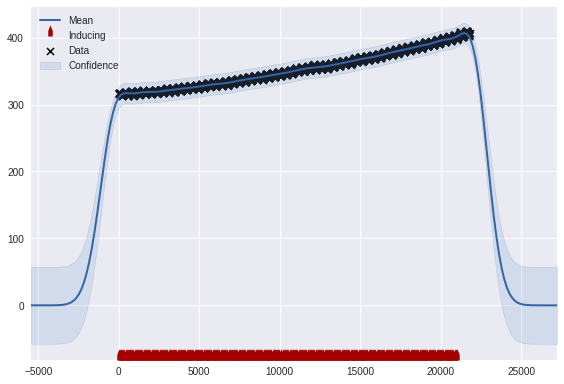

In [92]:
m.inducing_inputs.fix()
m.optimize('bfgs')
m.plot()
print (m)